In [1]:
from google.colab import drive
from torchvision.datasets import MNIST

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import time
import random
import os
import shutil
import csv
import math
import zipfile

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [6]:
class AnoMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoMNIST")
        assert os.path.exists(os.path.join(root_dir, "anomnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "anomnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


class AnomalyExtendedMNIST(datasets.MNIST):
    def __getitem__(self, idx):
        return super(AnomalyExtendedMNIST, self).__getitem__(idx)[0], {"label": super(AnomalyExtendedMNIST, self).__getitem__(idx)[1], "anomaly": False}

In [7]:
class AnoClassMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoClassMNIST")
        assert os.path.exists(os.path.join(root_dir, "ano_class_mnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "ano_class_mnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


class AnomalyExtendedMNIST(datasets.MNIST):
    def __getitem__(self, idx):
        return super(AnomalyExtendedMNIST, self).__getitem__(idx)[0], {"label": super(AnomalyExtendedMNIST, self).__getitem__(idx)[1], "anomaly": False}

In [18]:
def generate_lined_mnist_images(base_folder, num, max_augmentation_thickness=5,
                                randomize_augmentation_thickness=False, labels=[]):
    assert max_augmentation_thickness <= 7, "max_augmentation_thickness must be smaller than 7"
    os.makedirs(base_folder, exist_ok=True)

    dataset = datasets.MNIST(
        root=base_folder,
        train=True,
        download=True,
    )

    if len(labels) > 0:
        dataset = [d for d in dataset if (d[1] in labels)]
    else:
        dataset = dataset.data

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    augmentation_thickness: int = random.randint(1, max_augmentation_thickness)
    for i in range(num):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]

        augmentation_thickness = random.randint(3,
                                                max_augmentation_thickness) if randomize_augmentation_thickness else augmentation_thickness
        random_idx = random.randint(4, 20)
        for j in range(img.size[0]):
            for k in range(augmentation_thickness):
                img.putpixel((j, random_idx + k + 1), 0)

        img.save(os.path.join(ano_mnist_drop_folder, f"img_aug_{label}_{i}.png"))
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'img_aug_{label}_{i}.png', f"{label}", "True"]
            writer.writerow(fields)


def generate_anomalous_image_files(base_folder, num, labels=[], copy_zip_to=''):
    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "anomaly"]
        writer.writerow(fields)

    generate_lined_mnist_images(base_folder, num=num, labels=labels)
    if copy_zip_to:
      shutil.make_archive(os.path.join(copy_zip_to, "AnoMNIST"), 'zip', ano_mnist_drop_folder)

def get_ano_mnist_dataset(transform, root_dir, labels=[9], train_size=0.9):
    ano_mnist_dataset = AnoMNIST(
        root_dir=root_dir,
        transform=transform
    )

    mnist_dataset = AnomalyExtendedMNIST(
        root=root_dir,
        train=True,
        transform=transform,
        download=True,
    )

    dat = torch.utils.data.ConcatDataset([ano_mnist_dataset, mnist_dataset])

    if len(labels) > 0:
        dat = [d for d in dat if (d[1]['label'] in labels)]

    absolute_train_size = int(len(dat) * train_size)
    absolute_test_size = len(dat) - absolute_train_size
    return torch.utils.data.random_split(dat, [absolute_train_size, absolute_test_size])


def generate_ano_class_mnist_dataset(root_dir, norm_class=9, ano_class=6, ano_fraction=0.2, copy_zip_to='/content/drive/MyDrive/Colab/data'):
    if os.path.exists(root_dir):
        shutil.rmtree(root_dir)

    ano_mnist_drop_folder = os.path.join(root_dir, "AnoClassMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "ano_class_mnist_dataset.csv")

    os.makedirs(root_dir, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "anomaly"]
        writer.writerow(fields)

    mnist_dataset = MNIST(
        root=root_dir,
        train=True,
        download=True,
    )

    norms = [d for d in mnist_dataset if (d[1] == norm_class)]
    for i, img in enumerate(norms):
        img[0].save(os.path.join(ano_mnist_drop_folder, f"img_{norm_class}_{i}.png"))
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'img_{norm_class}_{i}.png', f"{norm_class}", "False"]
            writer.writerow(fields)


    anos = [d for d in mnist_dataset if (d[1] == ano_class)]
    anos = anos[:round(len(anos)*ano_fraction)]
    for i, img in enumerate(anos):
        img[0].save(os.path.join(ano_mnist_drop_folder, f"img_{ano_class}_{i}.png"))
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'img_{ano_class}_{i}.png', f"{ano_class}", "True"]
            writer.writerow(fields)

    if copy_zip_to:
      shutil.make_archive(os.path.join(copy_zip_to, "AnoClassMNIST"), 'zip', ano_mnist_drop_folder)


def get_ano_class_mnist_dataset(root_dir, train_size=0.9, batch_size=256):
    ano_mnist_dataset = AnoClassMNIST(
        root_dir=root_dir,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(.5,), std=(.5,))
        ])
    )

    return torch.utils.data.DataLoader(ano_mnist_dataset, batch_size=batch_size, shuffle=True)

In [19]:
generate_ano_class_mnist_dataset('/content/data', norm_class=9, ano_class=6, ano_fraction=0.2, copy_zip_to='/content/drive/MyDrive/Colab/data')

100%|██████████| 9912422/9912422 [00:00<00:00, 205725637.43it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 87589077.24it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 88044448.08it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18441944.60it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [20]:
def load_ano_mnist_from_drive(drop_folder):
  with zipfile.ZipFile('/content/drive/MyDrive/Colab/data/AnoMNIST.zip', 'r') as zip_ref:
    zip_ref.extractall(drop_folder)

def load_ano_class_mnist_from_drive(drop_folder):
    if os.path.exists(drop_folder):
        shutil.rmtree(drop_folder)

    os.makedirs(drop_folder, exist_ok=True)
    with zipfile.ZipFile('/content/drive/MyDrive/Colab/data/AnoClassMNIST.zip', 'r') as zip_ref:
        zip_ref.extractall(drop_folder)

In [23]:
batch_size = 512
num_classes = 1
learning_rate = 0.0001
num_epochs = 100
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100
adam_beta1 = 0.1
test_size = 1

In [24]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

#generate_anomalous_image_files(base_folder='/content/data', num=2000, labels=[9], copy_zip_to='/content/drive/MyDrive/Colab/data') # number of normals is: 5949
#load_ano_mnist_from_drive(drop_folder='/content/data')
#ano_mnist_dataset, _ = get_ano_mnist_dataset(transform=transform, root_dir='/content/data', labels=[9])
#dataset = get_ano_mnist_dataset(transform=transform, root_dir='/content/data', labels=[9])

load_ano_class_mnist_from_drive(drop_folder='/content/data/AnoClassMNIST')
ano_class_mnist_dataset = get_ano_class_mnist_dataset(root_dir='/content/data', batch_size=batch_size)

Save/Load models into generator and discriminator models

In [28]:
def save_checkpoint(epoch):
    print("Saving Checkpoint...")
    drive.mount('/content/drive', force_remount=True)
    timestamp = time.time()
    torch.save(generator.state_dict(),f'/content/drive/My Drive/Colab/saved_models/generator_epoch_{epoch}_{timestamp}.pkl')
    torch.save(discriminator.state_dict(),f'/content/drive/My Drive/Colab/saved_models/discriminator_epoch_{epoch}_{timestamp}.pkl')

def save_models():
    print("Saving Models...")
    drive.mount('/content/drive', force_remount=True)
    torch.save(generator.state_dict(),f'/content/drive/My Drive/Colab/saved_models/generator_latest.pkl')
    torch.save(discriminator.state_dict(),f'/content/drive/My Drive/Colab/saved_models/discriminator_latest.pkl')

def load_models():
    print("Loading Models...")
    drive.mount('/content/drive', force_remount=True)
    generator.load_state_dict(torch.load("/content/drive/My Drive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
    discriminator.load_state_dict(torch.load('/content/drive/My Drive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

Train the GAN

In [29]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, size_z, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

def train_gan(dataset):
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    #dataloader = torch.utils.data.DataLoader(dataset=dataset,
    #                                     batch_size=batch_size,
    #                                     shuffle=True)

    dataloader = dataset

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            # get batch-size from actual image batch
            bs = real_images.shape[0]

            # -- train discriminator --

            # reset/clear discriminators gradient
            discriminator.zero_grad()

            # move images to either CPU or GPU
            real_images = real_images.to(device)

            # creates a label tensor filled with 1s
            label = torch.full((bs,), real_label, dtype=torch.float, device=device)

            # get probs for discriminators guess on the real images
            output, _ = discriminator(real_images)

            # get loss for real images. that means it calculates the difference
            # between the output of the model with the current parameter and the
            # target (goal) of what the model is supposed to do
            # output --> current outcome of the model
            # label  --> target of the model
            lossD_real = criterion(output, label)

            # calculates the gradient (using chain-rule)
            # see https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
            lossD_real.backward()

            # Gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations (for real data ) --> D(x)
            D_x = output.mean().item()

            # create noise as an input for the G in order to create fake images
            noise = torch.randn(bs, size_z, 1, 1, device=device)

            # use generator to map input noise to an output that is supposed do become fake images during training
            fake_images = generator(noise)

            # creates a label tensor filled with 0s
            label.fill_(fake_label)

            # get discriminators guess on fake images
            output, _ = discriminator(fake_images.detach())

            # get loss for fake images
            lossD_fake = criterion(output, label)

            # adjust parameter to identify fakes
            lossD_fake.backward()

            # gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations. this time for the fake images that were
            # generated by the generator --> D(G(z))
            D_G_z1 = output.mean().item()

            # calculate loss
            lossD = lossD_real + lossD_fake

            # adjust models (discriminator) parameter
            optimizerD.step()

            # -- train generator --

            # reset/clear generators gradient
            generator.zero_grad()

            # creates a label tensor filled with 1s
            label.fill_(real_label)

            # get discriminators guess on fake images
            output, _ = discriminator(fake_images)
            output = output.view(-1)

            # get loss for fake images
            lossG = criterion(output, label)

            # adjust parameter to generate fakes
            lossG.backward()

            # gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations. this time for the fake images that were
            # generated by the generator --> D(G(z))
            D_G_z2 = output.mean().item()

            # adjust models (generator) parameter
            optimizerG.step()
            # Save Losses for plotting later
            G_losses.append(lossG.item())
            D_losses.append(lossD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1

        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch+1, num_epochs, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

        if epoch>0 and epoch%50 == 0:
          save_checkpoint(epoch)

    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.rcParams['animation.embed_limit'] = 100
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

Starting Training Loop...
[1/100]	Loss_D: 0.2537	Loss_G: 2.1973	D(x): 0.9286	D(G(z)): 0.1622 / 0.1153
[2/100]	Loss_D: 0.1280	Loss_G: 2.8388	D(x): 0.9609	D(G(z)): 0.0835 / 0.0609
[3/100]	Loss_D: 0.0702	Loss_G: 3.5371	D(x): 0.9715	D(G(z)): 0.0400 / 0.0305
[4/100]	Loss_D: 0.0349	Loss_G: 4.2034	D(x): 0.9844	D(G(z)): 0.0189 / 0.0154
[5/100]	Loss_D: 0.0184	Loss_G: 4.8473	D(x): 0.9913	D(G(z)): 0.0095 / 0.0081
[6/100]	Loss_D: 0.0116	Loss_G: 5.2235	D(x): 0.9951	D(G(z)): 0.0066 / 0.0056
[7/100]	Loss_D: 0.0079	Loss_G: 5.6052	D(x): 0.9966	D(G(z)): 0.0045 / 0.0038
[8/100]	Loss_D: 0.0058	Loss_G: 5.7722	D(x): 0.9979	D(G(z)): 0.0037 / 0.0032
[9/100]	Loss_D: 0.0047	Loss_G: 5.9787	D(x): 0.9983	D(G(z)): 0.0029 / 0.0026
[10/100]	Loss_D: 0.0051	Loss_G: 5.9333	D(x): 0.9981	D(G(z)): 0.0032 / 0.0027
[11/100]	Loss_D: 0.0059	Loss_G: 5.7865	D(x): 0.9986	D(G(z)): 0.0044 / 0.0031
[12/100]	Loss_D: 0.0035	Loss_G: 6.3272	D(x): 0.9986	D(G(z)): 0.0021 / 0.0018
[13/100]	Loss_D: 0.0104	Loss_G: 5.5893	D(x): 0.9985	D(G(z))

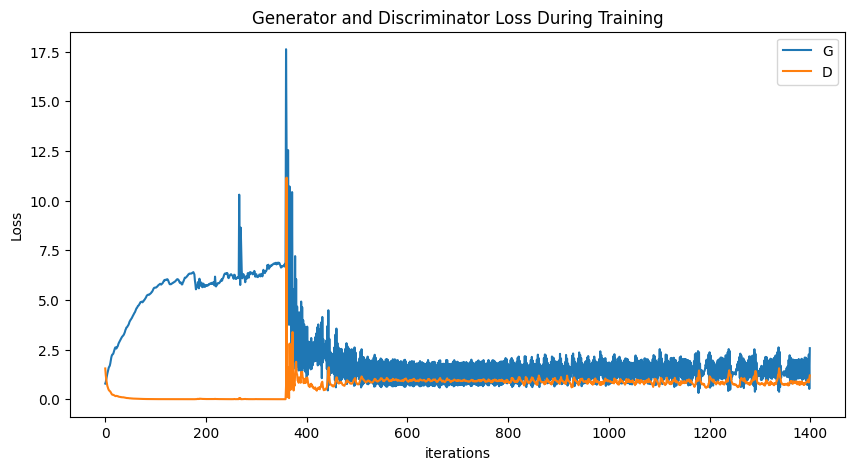

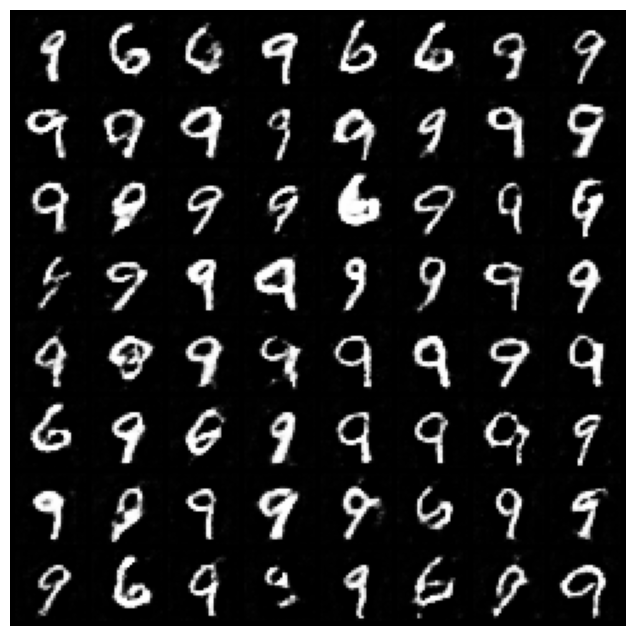

In [30]:
# train_gan(ano_mnist_dataset)
# data = get_ano_class_mnist_dataset(root_dir='/content/drive/MyDrive/Colab/data', ano_fraction=0.2)
train_gan(ano_class_mnist_dataset)

In [31]:
save_models()

Saving Models...
Mounted at /content/drive


Inference

In [ ]:
def generate_anomaly():
    random_idx = random.randint(0, len(test_dataset.data)-1)
    img, _ = test_dataset[random_idx]
    img = img.numpy()
    random_idx = random.randint(4, 20)
    img[0][random_idx:random_idx + 3] = np.ones(28, dtype="float32") - 2

    return np.expand_dims(img, axis=0)

def generate_normals_set(size):
    i = torch.from_numpy(np.random.randint(len(test_dataset)-1, size=size))
    train_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
    data = next(iter(train_loader))[0].numpy()[i]
    if len(data.shape) == 3: data = np.expand_dims(data, axis=0)

    return torch.from_numpy(data)

def generate_anomaly_set(size):
    anomalies = generate_anomaly()
    for i in range(size-1):
        anomalies = np.concatenate((anomalies, generate_anomaly()))

    return torch.from_numpy(anomalies)

def generate_test_set(size_normals, size_anomalies):
    normals = generate_normals_set(size_normals)
    anomalies = generate_anomaly_set(size_anomalies)

    return normals, anomalies

In [ ]:
def get_anomaly_score(z, x_query):
    lamda = 0.1
    g_z = generator(z.to(device))
    _, x_prop = discriminator(x_query)
    _, g_z_prop = discriminator(g_z)

    loss_r = torch.sum(torch.abs(x_query - g_z))
    loss_d = torch.sum(torch.abs(x_prop - g_z_prop))

    return (1 - lamda) * loss_r + lamda * loss_d

In [ ]:
def run_inference(query_image, input_type, draw_loss_curve, opt_iterations = 10000, draw_result = True):
    z = torch.randn(test_size, size_z, 1, 1, device=device, requires_grad=True).to(device)
    z_optimizer = torch.optim.Adam([z], lr=1e-4)
    losses = []
    score = 0

    for i in range(opt_iterations):
        loss = get_anomaly_score(z, query_image.unsqueeze(0).to(device))
        loss.backward()
        z_optimizer.step()
        if i % 500==0:
            losses.append(loss.data.item())
        if i == opt_iterations - 1: score = loss.data.item()

    if draw_loss_curve:
        plt.figure(figsize=(10, 5))
        plt.title("Loss trajectory during optimization")
        plt.plot(losses, label="Loss")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    if draw_result: draw_results(z, query_image, input_type, score)

    if not draw_result: print(f"Ran Inference with {opt_iterations} iterations. Query-Type was {input_type}. Anonaly-Score: {score}")
    return score

def draw_results(z, query_image, input_type, score):
    gen_fake = generator(z.to(device))
    target = query_image.squeeze().numpy()
    img = gen_fake.detach().numpy().squeeze()

    num_rows = 1
    images_in_row = 4
    f, ax = plt.subplots(num_rows, images_in_row, figsize=(10,4))

    f.add_subplot(num_rows, images_in_row, 1)
    plt.imshow(target, cmap="binary")
    plt.axis('off')
    plt.title("Query Image")

    f.add_subplot(num_rows, images_in_row, 2)
    plt.imshow(img, cmap="binary")
    plt.axis('off')
    plt.title("G(z_Gamma)")

    diff = np.abs(img - target)*255
    diff_isclose = np.isclose(img, target, rtol=1.2, atol=0.4)

    f.add_subplot(num_rows, images_in_row, 3)
    plt.imshow(Image.fromarray(diff), cmap="binary")
    plt.axis('off')
    plt.title("|G(z_Gamma) - x|")

    f.add_subplot(num_rows, images_in_row, 4)
    plt.imshow(Image.fromarray(diff_isclose), cmap="binary")
    plt.axis('off')
    plt.title("np.isclose()")

    f.suptitle(f'Sample Type: {input_type} - Score: {score}', fontsize=14)
    plt.show()

def create_roc_curve(file_path):
    data = pd.read_csv(file_path, delimiter=';').iloc[: , 1:].to_numpy()
    y_label, y_scores = np.hsplit(data, 2)
    y_label = y_label.reshape(len(y_label))
    y_scores = np.array(y_scores.reshape(len(y_scores)), dtype='float64')
    label_dict = {'normal': 0, 'anomaly': 1}
    y_label = np.array([label_dict[y_i] for y_i in y_label])

    fpr, tpr, _ = roc_curve(y_label, y_scores)
    auc_value = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title(f"ROC Curve - AUC: {auc_value}", fontsize=18)
    plt.xlabel("FPR", fontsize=14)
    plt.ylabel("TPR", fontsize=14)
    plt.legend()

def test_inference(size_normals, size_anomalies, draw_loss_curve = False, save_statistics = True, draw_result = True, opt_iterations = 10000):
    statistics = {
        "sample-type": [],
        "score": []
    }

    normals, anomalies = generate_test_set(size_normals, size_anomalies)
    for n in normals:
        score = run_inference(n, 'NORMAL', draw_loss_curve=draw_loss_curve, opt_iterations = opt_iterations, draw_result = draw_result)
        if save_statistics:
            statistics["sample-type"].append("normal")
            statistics["score"].append(round(score, 2))
    for a in anomalies:
        score = run_inference(a, 'ANOMALY', draw_loss_curve=draw_loss_curve, opt_iterations = opt_iterations, draw_result = draw_result)
        if save_statistics:
            statistics["sample-type"].append("anomaly")
            statistics["score"].append(round(score, 2))
    if save_statistics:
        timestr = time.strftime('%d %b %Y %H:%M:%S GMT', time.localtime())
        df = pd.DataFrame(statistics)
        df.to_csv(f'./data/statistics/stat_{timestr}.csv', sep=';')


In [ ]:
# load_models()
# test_inference(80, 20, draw_loss_curve = False, save_statistics = True, draw_result = True, opt_iterations = 10000)

In [ ]:
# file = './data/statistics/stat_02 Apr 2023 17:30:50 GMT.csv'
# create_roc_curve(file)

In [ ]:
# train_gan(ano_mnist_dataset)

In [ ]:
# save_models()